In [1]:
import pandas as pd
import json
import os
import numpy as np

In [3]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
#statistics
from sklearn import linear_model
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy import stats
import statsmodels.stats.multitest as multi

In [8]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [9]:
with open('/cellar/controlled/dbgap-genetic/ICB/rna/TPMs/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
tpm=pd.DataFrame.from_dict(icb_tpm)

PermissionError: [Errno 13] Permission denied: '/cellar/controlled/dbgap-genetic/ICB/rna/TPMs/all_immunotherapy_tpm.json'

In [ ]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get PD-1/PD-L1

In [ ]:
#analyze TPM rna
rna=tpm.copy()
rna+=1
rna=np.log2(rna)

In [ ]:
rna.index=rna.index.str.split(".").str[0]
rna["gene name"]=rna.index.map(ensembl)
rna=rna[~(rna["gene name"].isnull())]
rna.index=rna["gene name"]
del rna["gene name"]
rna=rna.T
rna.index=rna.index.str.split(".sra").str[0]
rna=rna.reset_index()
rna=rna.rename(columns={"index":"FID"})

In [ ]:
#get mapping file
mapping=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
print(len(mapping["normal WXS id"].unique()))
mapping=mapping[~(mapping["tumor RNA id"].isnull())]

In [ ]:
mp_study=dict(zip(mapping["tumor RNA id"],mapping["study"]))
mp_time=dict(zip(mapping["tumor RNA id"],mapping["Biopsy Time"]))
mp_response=dict(zip(mapping["normal WXS id"],mapping["Response"]))
mp_rna2geno=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

mp_tmr2geno={}
for i,row in mapping.iterrows():
    for x in row["tumor WXS id"].split(", "):
        mp_tmr2geno[x]=row["normal WXS id"]

In [ ]:
rna["study"]=rna["FID"].map(mp_study)
rna["time"]=rna["FID"].map(mp_time)

rna["FID"]=rna["FID"].map(mp_rna2geno)
rna_filt=rna[~(rna["FID"].isnull())]

rna_filt["response"]=rna_filt["FID"].map(mp_response)

dict_response={"Progressive Disease":"PD","Partial Response":"PR","Complete Response":"CR"}
rna_filt=rna_filt.replace({"response": dict_response})
rna_filt_pre=rna_filt[~rna_filt["time"].isin(["On","on-treatment"])]

In [ ]:
ic_exp=rna_filt_pre[["FID","PDCD1","CD274","CTLA4"]]

### Get TMB

In [ ]:
tmb=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/tmb/mutect.filtered.muts.tsv",delimiter="\t")
tmb=tmb[["tumor_id"]].groupby(["tumor_id"]).size().reset_index()
tmb.columns=["tumor_id","TMB"]

In [ ]:
tmb["FID"]=tmb["tumor_id"].map(mp_tmr2geno)

In [ ]:
tmb=tmb[~tmb["FID"].isnull()]

In [ ]:
tmb=tmb[["FID","TMB"]].groupby(["FID"]).mean().reset_index()

In [ ]:
print(len(tmb))

### Get germline PRS

In [95]:
compiled_prs=pd.read_csv("../data/icb-response/burden-score/burden.fdr.5.csv")

In [96]:
compiled_prs=compiled_prs[["FID","burden","pheno","study"]]

### Get covariate

In [97]:
cov=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/covar/total.cov.age.sex.study.v2.txt",delimiter="\t")

### Combine

In [98]:
markers=pd.merge(ic_exp,tmb[["FID","TMB"]],on="FID",how="left")
markers=pd.merge(markers,compiled_prs,on="FID",how="outer")
markers=pd.merge(markers,cov,on=["FID"])
markers=markers[~markers["study"].isnull()]

In [99]:
markers["response"]=markers["pheno"].map({2:1,1:0})

In [100]:
markers.to_csv("../data/r2/icb.pd1.pdl1.tmb.germline.tsv",index=None,sep="\t")

### Run OLS with markers

In [101]:
beta=[]
pval=[]
marker_lst=[]
study_lst=[]

for study in markers["study"].unique():
    
    for marker in ["PDCD1","CD274","CTLA4","TMB"]:
        try:
            markers_study=markers[markers["study"]==study]
            markers_study=markers_study[~markers_study[marker].isnull()]
        
            ols = linear_model.LinearRegression()
            X=markers_study[[marker,"Age","Gender","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]]
            y=markers_study["pheno"].values.reshape(-1, 1)
        
            X = sm.add_constant(X)
        
            model=sm.OLS(y,X)
            results=model.fit()
        
            beta.append(results.params[1])
            pval.append(results.pvalues[1])
            marker_lst.append(marker)
            study_lst.append(study)
        except:
            beta.append(0)
            pval.append(0)
            marker_lst.append(marker)
            study_lst.append(study)
            pass

df_ols=pd.DataFrame({"markers":marker_lst,"study":study_lst,"beta":beta,"p":pval})
        

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [102]:
df_ols=df_ols[df_ols["study"].isin(["riaz","miao","vanallen","hugo","rizvi","snyder"])]

In [103]:
df_ols["-log10p"]=-np.log10(df_ols["p"])

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [104]:
df_ols=df_ols.sort_values(by="study")

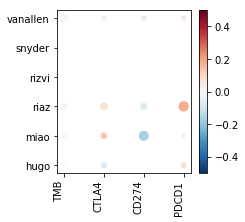

In [220]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 100
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_ols['markers'],
    y=df_ols['study'],
    size=df_ols['-log10p'],
    color=df_ols['beta'],
)

plt.savefig("../plots/fig7/study.markers.clustermap.pdf")

In [222]:
df_avg=markers[["TMB","CTLA4","CD274","PDCD1","study"]].groupby("study").mean().reset_index()
df_avg=df_avg[df_avg["study"].isin(["hugo","miao","riaz","vanallen"])]

df_mean=df_avg.mean().reset_index()
df_mean.columns=["gene","mean"]

df_std=df_avg.std().reset_index()
df_std.columns=["gene","std"]

df_plot=pd.merge(df_mean,df_std,on="gene",how="left")

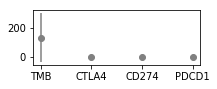

In [241]:
fig = plt.figure(figsize=(3,1))
plt.errorbar(x=df_plot.gene.tolist(),y=df_plot["mean"].tolist(),yerr=df_plot["std"].tolist(),fmt="o",color="gray")
plt.savefig("../plots/fig7/io.error.pdf")

### Get association of CTSS variant with RNA

In [16]:
raw=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/icb-genotypes/all.time.raw",delim_whitespace=True)

In [17]:
rna_pre=rna[~rna["time"].isin(["On"])]
raw_rna=pd.merge(raw,rna_pre,on="FID",how="left")

In [18]:
ciber=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/pheno.cibersortx.txt",delimiter="\t")
ciber["FID"]=ciber["FID"].str.split(".").str[0]

In [19]:
raw_rna=pd.merge(raw_rna,ciber,on="FID",how="left")

In [20]:
raw_rna["response"]=raw_rna["FID"].map(mp_response)
raw_rna=raw_rna.replace({"response": dict_response})

In [21]:
raw_rna

,FID,IID_x,PAT,MAT,SEX,PHENOTYPE,1:1421752:G:A_A,1:7833228:A:G_G,1:7836659:A:C_C,1:7836798:A:G_G,...,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,M1.M2,response
0,SRR478575,SRR478575,0,0,0,-9,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SRR478621,SRR478621,0,0,0,-9,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SRR478648,SRR478648,0,0,0,-9,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SRR478798,SRR478798,0,0,0,-9,1,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SRR478821,SRR478821,0,0,0,-9,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,SRR10899963,SRR10899963,0,0,0,-9,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD
874,SRR10899966,SRR10899966,0,0,0,-9,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD
875,SRR10899968,SRR10899968,0,0,0,-9,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CR
876,SRR10899971,SRR10899971,0,0,0,-9,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD


In [22]:
raw_rna["CTSS_snp"]=np.where(raw_rna["1:150958977:T:C_C"]>0,1,0)
raw_rna["CTSW_snp"]=np.where(raw_rna["11:65712413:G:A_A"]>0,1,0)
raw_rna["FAM216A_snp"]=np.where(raw_rna["12:110857324:C:T_T"]>0,1,0)
raw_rna["LYZ_snp"]=np.where(raw_rna["12:69794086:C:G_C"]>0,1,0)
raw_rna["C3AR1_snp"]=np.where(raw_rna["12:8210697:A:G_A"]>0,1,0)
raw_rna["DCTN5_snp"]=np.where(raw_rna["16:23621132:T:C_C"]>0,1,0)
raw_rna["DBNDD1_snp"]=np.where(raw_rna["16:90080852:C:T_T"]>0,1,0)
raw_rna["FPR1_snp"]=np.where(raw_rna["19:52249702:G:T_T"]>0,1,0)
raw_rna["TREX1_snp"]=np.where(raw_rna["3:47587905:A:G_A"]>0,1,0)
raw_rna["DHFR_snp"]=np.where(raw_rna["5:80279422:T:G_T"]>0,1,0)
raw_rna["ERAP1_snp"]=np.where(raw_rna["5:96103589:G:A_A"]>0,1,0)
raw_rna["ERAP2_snp"]=np.where(raw_rna["5:96229542:T:G_G"]>0,1,0)
raw_rna["DYNLT1_snp"]=np.where(raw_rna["6:159050889:C:T_T"]>0,1,0)
raw_rna["GPLD1_snp"]=np.where(raw_rna["6:24560002:A:T_T"]>0,1,0)
raw_rna["PSMD11_snp"]=np.where(raw_rna["9:34549235:C:G_G"]>0,1,0)

In [25]:
def plot_snp(df,snp_lst,gene_lst):
    
    for snp in snp_lst:
    
        for gene in gene_lst:
            
            #if snp.rsplit("_")[0]==gene:
        
            fig = plt.figure(figsize=(5,5))
            ax=sns.boxplot(x="study",y=gene,hue=snp,data=raw_rna)

            #get p-values
            labels=[item.get_text() for item in ax.get_xticklabels()]

            new_labels=[]
            for x in labels:
                raw_rna_study=raw_rna[raw_rna["study"]==x]
                cat0 = raw_rna_study[raw_rna_study[snp]==0]
                cat1 = raw_rna_study[raw_rna_study[snp]!=0]
                p=mannwhitneyu(cat0[gene], cat1[gene])[1]
                new_labels.append(x+"\n{0:.4f}".format(p))
            ax.set_xticklabels(new_labels)

        #plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig7/"+snp+"."+gene+".pdf")
        

In [26]:
raw_rna["M1_M2+M0"]=raw_rna["Macrophages.M1"]/(raw_rna["Macrophages.M2"]+raw_rna["Macrophages.M0"])

In [28]:
raw_rna

,FID,IID_x,PAT,MAT,SEX,PHENOTYPE,1:1421752:G:A_A,1:7833228:A:G_G,1:7836659:A:C_C,1:7836798:A:G_G,...,DBNDD1_snp,FPR1_snp,TREX1_snp,DHFR_snp,ERAP1_snp,ERAP2_snp,DYNLT1_snp,GPLD1_snp,PSMD11_snp,M1_M2+M0
0,SRR478575,SRR478575,0,0,0,-9,0,0,0,0,...,1,1,1,1,0,1,1,1,0,NaN
1,SRR478621,SRR478621,0,0,0,-9,0,1,1,1,...,1,1,1,0,0,0,1,0,1,NaN
2,SRR478648,SRR478648,0,0,0,-9,0,1,1,1,...,1,1,1,0,0,1,1,0,0,NaN
3,SRR478798,SRR478798,0,0,0,-9,1,0,2,0,...,0,0,1,0,0,0,1,0,0,NaN
4,SRR478821,SRR478821,0,0,0,-9,0,0,2,0,...,0,1,0,0,0,0,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,SRR10899963,SRR10899963,0,0,0,-9,0,0,1,0,...,0,1,1,0,1,0,1,0,0,NaN
874,SRR10899966,SRR10899966,0,0,0,-9,0,0,1,0,...,1,0,0,0,0,0,0,1,0,NaN
875,SRR10899968,SRR10899968,0,0,0,-9,0,0,0,0,...,1,0,1,0,0,0,0,0,0,NaN
876,SRR10899971,SRR10899971,0,0,0,-9,0,1,1,1,...,0,1,0,1,0,0,1,1,0,NaN


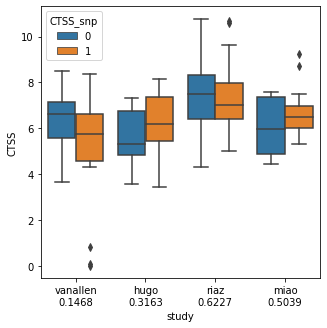

In [27]:
#plot_snp(raw_rna,["CTSS_snp","CTSW_snp","FAM216A_snp","LYZ_snp","C3AR1_snp","DCTN5_snp","DBNDD1_snp","FPR1_snp","TREX1_snp","DHFR_snp","ERAP1_snp","ERAP2_snp","DYNLT1_snp","GPLD1_snp","PSMD11_snp"],["CTSS","CTSW","FAM216A","LYZ","C3AR1","DCTN5","DBNDD1","FPR1","TREX1","DHFR","ERAP1","ERAP2","DYNLT1","GPLD1","PSMD11"])
plot_snp(raw_rna,["CTSS_snp"],["CTSS"])


### Get association of TREX1 variant with RNA

In [127]:
raw_rna["3:47587905:A:G_A_snp"]=np.where(raw_rna["3:47587905:A:G_A"]>0,1,0)
raw_rna["3:48591481:C:T_C_snp"]=np.where(raw_rna["3:48591481:C:T_C"]>0,1,0)

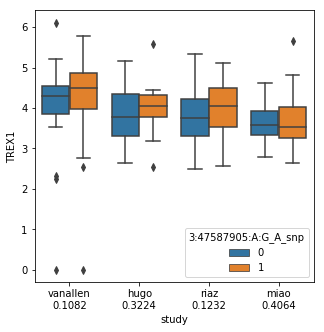

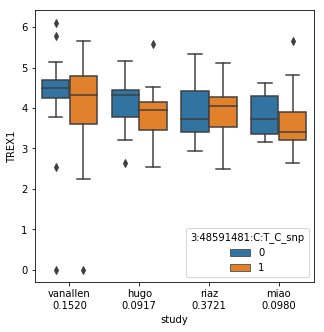

In [128]:
plot_snp(raw_rna,["3:47587905:A:G_A_snp","3:48591481:C:T_C_snp"],["TREX1"])

### Get RNA associations

In [224]:
rna_dir="../data/icb-associations/bycohort/"
rna_assoc=pd.DataFrame()

for x in [x for x in os.listdir(rna_dir) if "linear" in x]:
    rna=pd.read_csv(rna_dir+x,delimiter="\t")
    rna["file"]=x.split(".")[1]
    rna["cohort"]=x.split(".")[0]
    rna_assoc=rna_assoc.append(rna)

rna_assoc=rna_assoc[rna_assoc["TEST"]=="ADD"].sort_values(by="P")
rna_io=rna_assoc[rna_assoc["file"].isin(["TMB","PDCD1","CD274","CTLA4"])]
rna_io["-log10p"]=-np.log10(rna_io["P"])
rna_io["ID_cohort"]=rna_io["ID"]+"_"+rna_io["cohort"]
rna_io=rna_io.sort_values(by=["#CHROM","POS","cohort"])

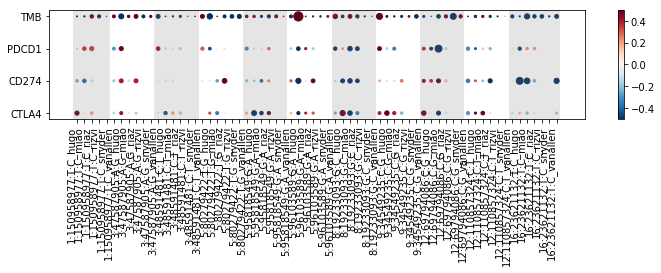

In [262]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 20
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    ax.axvspan(-0.5, 4.5, facecolor='gray', alpha=0.2)
    ax.axvspan(10.5, 16.5, facecolor='gray', alpha=0.2)
    ax.axvspan(22.5, 28.5, facecolor='gray', alpha=0.2)
    ax.axvspan(34.5, 40.5, facecolor='gray', alpha=0.2)
    ax.axvspan(46.5, 52.5, facecolor='gray', alpha=0.2)
    ax.axvspan(58.5, 65.5, facecolor='gray', alpha=0.2)
    
    
heatmap(
    x=rna_io['ID_cohort'],
    y=rna_io['file'],
    size=rna_io['-log10p'],
    color=rna_io['BETA'],
)



plt.savefig("../plots/fig7/study.icb.io.clustermap.pdf")

In [81]:
cohort_lst=[]

for i in range(11):
    for cohort in ["hugo","miao","riaz","rizvi","snyder","vanallen"]:
        cohort_lst.append(cohort)    
df=pd.DataFrame({"cohort":cohort_lst})
mp_cohort_color={"hugo":"#1b9e77","miao":"#d95f02","riaz":"#7570b3","rizvi":"#e7298a","snyder":"#66a61e","vanallen":"#e6ab02"}
df["color"]=df["cohort"].map(mp_cohort_color)
df["value"]=1
df["cohort"]=df["cohort"]+df.index.astype(str)
fig, ax = plt.subplots(figsize=(12, 4))
plt.bar(df["cohort"].tolist(),df["value"].tolist(),color=df["color"].tolist())
plt.savefig("../plots/fig5/cohort.io.legend.pdf")

In [90]:
rna_dir="../data/icb-associations/"

rna_assoc=pd.DataFrame()

for x in [x for x in os.listdir(rna_dir) if "linear" in x]:
    rna=pd.read_csv(rna_dir+x,delimiter="\t")
    rna["file"]=x
    rna_assoc=rna_assoc.append(rna)

rna_assoc=rna_assoc[rna_assoc["TEST"]=="ADD"].sort_values(by="P")
rna_assoc["file"]=rna_assoc["file"].str.split(".").str[4]
    

In [101]:
rna_io=rna_assoc[rna_assoc["file"].isin(["TMB","PDCD1","CD274","CTLA4"])]
rna_io["-log10p"]=-np.log10(rna_io["P"])
rna_io["index"]=rna_io["file"].map({"TMB":3,"PDCD1":2,"CD274":1,"CTLA4":1})
rna_io=rna_io.sort_values(by=["#CHROM","POS","index"])

/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


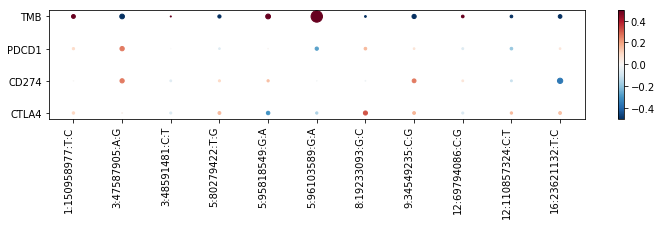

In [102]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 20
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=rna_io['ID'],
    y=rna_io['file'],
    size=rna_io['-log10p'],
    color=rna_io['BETA'],
)

plt.savefig("../plots/fig7/study.icb.io.cov.clustermap.pdf")